# Naturalistic EMA validation

Applying the findings from the 4-state correlation work (EMA x UPDRS) onto real-life EMA data.

Goals:
- analyse real-life variation of EMA values
    - inter-individual variation
    - intra-individual variation, daily fluctuations, differences between days

## 0. Import packages

- document versions for reproducibility

In [1]:
# import packages
import datetime as dt
import pandas as pd
import numpy as np
import os
import sys
import csv
import json
import importlib
from itertools import product, compress
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.signal import welch

In [2]:
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
# print('sci-py', scipy.__version__)
# print('sci-kit learn', sk.__version__)
# print('matplotlib', plt_version)

"""
Python sys 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
pandas 2.1.1
numpy 1.26.0

from 16.09

Python sys 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
pandas 2.3.2
numpy 2.3.3
"""

Python sys 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
pandas 2.3.2
numpy 2.3.3


'\nPython sys 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]\npandas 2.1.1\nnumpy 1.26.0\n\nfrom 16.09\n\nPython sys 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]\npandas 2.3.2\nnumpy 2.3.3\n'

Import custom functions

In [ ]:
import dbs_home

# from dbs_home repo
from dbs_home.load_raw.main_load_raw import loadSubject 
import dbs_home.utils.helpers as home_helpers
import dbs_home.utils.ema_utils as home_ema_utils
import dbs_home.plot_data.plot_compliance as plot_home_compl
import dbs_home.preprocessing.preparing_ema as home_ema_prep

In [4]:
# from current repo
from utils import load_utils, load_data, prep_data
from plotting import plot_help



## 1. Import Home-Data

Use pre-operative sessions

- use 9-point-converter
- use direct. inverter

Import EMA home data from raw files

In [5]:
MOMENTS = ['pre-op', 'pre 3MFU', 'post 3MFU']

sub_skip = [] # ['hm25',]  # skip full subject
# skip per session
ses_skip = [['hm20', 'ses03'],]
# ses_skip = [['hm14', 'ses03']]

In [6]:
sessions_include = {m: {} for m in MOMENTS}

for rec_moment in MOMENTS:

    sel_info = home_helpers.select_sessions(target_session=rec_moment)
    sel_info = sel_info.set_index(sel_info['study_id'],)
    sel_sessions = {sub: ses for sub, ses in sel_info[['study_id', 'Session']].values}

    for key, val in sel_sessions.items():
        sessions_include[rec_moment][key] = val


In [7]:
print(sessions_include.keys())
print(sessions_include)

dict_keys(['pre-op', 'pre 3MFU', 'post 3MFU'])
{'pre-op': {'hm12': 'ses01', 'hm14': 'ses01', 'hm17': 'ses01', 'hm18': 'ses01', 'hm19': 'ses01', 'hm20': 'ses01', 'hm21': 'ses01', 'hm22': 'ses01', 'hm23': 'ses01', 'hm24': 'ses01', 'hm25': 'ses01', 'hm26': 'ses01', 'hm27': 'ses01', 'hm28': 'ses01'}, 'pre 3MFU': {'hm14': 'ses02', 'hm12': 'ses02', 'hm18': 'ses02', 'hm19': 'ses02', 'hm21': 'ses02', 'hm23': 'ses02', 'hm24': 'ses02'}, 'post 3MFU': {'hm10': 'ses01', 'hm13': 'ses01', 'hm16': 'ses01', 'hm14': 'ses03', 'hm12': 'ses03'}}


Load data

dev for EMA


In [9]:
importlib.reload(home_ema_utils)
importlib.reload(load_data)
importlib.reload(prep_data)
importlib.reload(home_ema_prep)

# load all combined data

# SUBS_INCL = ['hm14']


data = {m: {} for m in MOMENTS}

for rec_moment, sub_sess in sessions_include.items():
    # rec_moment contains 'pre-op', or 'pre 3MFU', 'post 3MFU', etc
    for sub, ses in sub_sess.items():

        if sub in sub_skip: continue
                    
        if [sub, ses] in ses_skip: continue
                
        ses_class = loadSubject(
            sub=sub,
            ses=ses,
            incl_EMA=True,
            incl_ACC=False,
        )
        temp_df = home_ema_utils.load_ema_df(sub_ses_class=ses_class)
        # prepare
        temp_df = home_ema_prep.prepare_ema_df(temp_df, ADD_MEANMOVE=True, INVERT_NEG_ITEMS=False,)
        ### TODO: CHECK WHY NOT ALL SUBS ARE INVERTED PROPERLY

        data[rec_moment][sub] = temp_df


first session day 2025-03-14
last session day 2025-04-03
	...importing EMA data
all EMA-data loaded
first session day 2025-03-21
last session day 2025-03-24
	...importing EMA data
all EMA-data loaded
first session day 2025-05-13
last session day 2025-06-02
	...importing EMA data


C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\utils\ema_utils.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col_dt = pd.to_datetime(col, errors='coerce', utc=True)
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\preprocessing\preparing_ema.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: np.nan if x is None else x)
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\preprocessing\preparing_ema.py:50: RuntimeWarning: Mean of empty slice
  df['move_mean'] = np.nanmean(
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\utils\ema_utils.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure par

all EMA-data loaded
first session day 2025-05-31
last session day 2025-06-10
	...importing EMA data
all EMA-data loaded
first session day 2025-05-31
last session day 2025-06-16
	...importing EMA data
all EMA-data loaded


C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\utils\ema_utils.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col_dt = pd.to_datetime(col, errors='coerce', utc=True)
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\preprocessing\preparing_ema.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: np.nan if x is None else x)
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\preprocessing\preparing_ema.py:50: RuntimeWarning: Mean of empty slice
  df['move_mean'] = np.nanmean(
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\utils\ema_utils.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure par

first session day 2025-05-31
last session day 2025-06-27
	...importing EMA data
all EMA-data loaded
first session day 2025-07-02
last session day 2025-07-14
	...importing EMA data
all EMA-data loaded


C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\utils\ema_utils.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col_dt = pd.to_datetime(col, errors='coerce', utc=True)
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\preprocessing\preparing_ema.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: np.nan if x is None else x)
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\preprocessing\preparing_ema.py:50: RuntimeWarning: Mean of empty slice
  df['move_mean'] = np.nanmean(
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\utils\ema_utils.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure par

first session day 2025-07-05
last session day 2025-07-27
	...importing EMA data
all EMA-data loaded
first session day 2025-07-12
last session day 2025-07-25
	...importing EMA data
all EMA-data loaded


C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\utils\ema_utils.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col_dt = pd.to_datetime(col, errors='coerce', utc=True)
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\preprocessing\preparing_ema.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: np.nan if x is None else x)
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\preprocessing\preparing_ema.py:50: RuntimeWarning: Mean of empty slice
  df['move_mean'] = np.nanmean(
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\utils\ema_utils.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure par

first session day 2025-07-12
last session day 2025-08-18
	...importing EMA data
all EMA-data loaded
first session day 2025-08-09
last session day 2025-09-05
	...importing EMA data
all EMA-data loaded


C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\utils\ema_utils.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col_dt = pd.to_datetime(col, errors='coerce', utc=True)
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\preprocessing\preparing_ema.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: np.nan if x is None else x)
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\preprocessing\preparing_ema.py:50: RuntimeWarning: Mean of empty slice
  df['move_mean'] = np.nanmean(
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\utils\ema_utils.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure par

first session day 2025-09-03
last session day 2025-09-18
	...importing EMA data
all EMA-data loaded
first session day 2025-09-05
last session day 2025-09-26
	...importing EMA data
all EMA-data loaded


C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\utils\ema_utils.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col_dt = pd.to_datetime(col, errors='coerce', utc=True)
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\preprocessing\preparing_ema.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: np.nan if x is None else x)
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\preprocessing\preparing_ema.py:50: RuntimeWarning: Mean of empty slice
  df['move_mean'] = np.nanmean(
C:\Users\habetsj\Research\projects\HOME_DBS\code\dbs_in_the_wild\src\dbs_home\utils\ema_utils.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure par

AssertionError: C:\Users\habetsj\OneDrive - Charité - Universitätsmedizin Berlin\HOME monitoring PREP\HOME_DATA\raw_data\hm28 does not exist

## 2. Explore naturalistic EMAs

Preprocess EMA

- merge scores
- invert negative-items (higher = clinically better)
- mean-correct EMA
    - test different normalizations:
        - normalize with grand-mean per sub
        - normalize with session mean

In [8]:
importlib.reload(prep_data)

allsubs = []
for mom in list(data.keys()): allsubs.extend(list(data[mom].keys()))
allsubs = np.unique(allsubs)


corr_data = {m: {} for m in MOMENTS}

for sub in allsubs:

    subdf = home_ema_prep.merge_sub_ema_df(datadict=data, sub=sub)
    subdf = home_ema_prep.mean_correct_ema_df(subdf)

    # split and palce back as moment dfs    
    for moment in MOMENTS:
        corr_data[moment][sub] = subdf[subdf['moment'] == moment].reset_index(drop=True)



NameError: name 'data' is not defined

Visualize first EMA results full group

In [ ]:
PLOT_ITEMS = ['move_mean', 'walking', 'tremor']

PLOT_CORR = False
if PLOT_CORR: PLOT_DATADICT = corr_data
else: PLOT_DATADICT = data


fig, axes = plt.subplots(3, 1, figsize=(9, 6))
fname = 'motorItems_abs_perSub_perSes_1104'
if PLOT_CORR: fname = fname.replace('abs', 'corr')

x_margin = 2
bin_w = 0.5

fsize=14

x_starts = {list(data.keys())[0]: 0}  # first moment starts at 0

subcolors = plot_help.get_sub_colors(PLOT_DATADICT)


for i_ax, col in enumerate(PLOT_ITEMS):

    for i_mom, moment in enumerate(PLOT_DATADICT.keys()):

        if PLOT_CORR and i_mom == 0: col = f'{col}_corr'

        # loop over sub-dfs within moment and add specific column values
        list_values = [tempdf[col].values for tempdf in PLOT_DATADICT[moment].values()]
        box_subs = list(PLOT_DATADICT[moment].keys())  # subs included in this boxplot
        # sort by sub id
        i_sort = np.argsort(box_subs)
        box_subs = [box_subs[i] for i in i_sort]
        list_values = [list_values[i] for i in i_sort]

        # drop NaN values in lists
        list_values = [[v for v in l if not np.isnan(v)] for l in list_values]

        # plot boxes for one moment
        bp = axes[i_ax].boxplot(list_values, widths=bin_w,
                           positions=x_starts[moment] + bin_w * np.arange(len(list_values)),
                           patch_artist=True,)
        if i_ax == 0:
            if moment != list(PLOT_DATADICT.keys())[-1]:
                x_starts[list(PLOT_DATADICT.keys())[i_mom + 1]] = x_starts[moment] + len(list_values) * bin_w + x_margin

        # Loop over boxes
        for patch, patchsub in zip(bp['boxes'], box_subs):
            patch.set_facecolor(subcolors[patchsub])

    # pretty plot
    axes[i_ax].set_ylabel(f'{col}\n(EMA answer)', size=fsize,)

# pretty axes
for ax in axes:
    if not PLOT_CORR:
        ax.set_ylim(0, 10)
        ax.set_yticks(np.arange(1, 10, 2))
        ax.set_yticklabels(np.arange(1, 10, 2))
    else:
        ax.set_ylim(-5, 5)
        ax.set_yticks(np.arange(-4, 6, 2))
        ax.set_yticklabels(np.arange(-4, 6, 2))

    ax.set_xticks(list(x_starts.values()))
    ax.set_xticklabels(list(x_starts.keys()))
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', labelsize=fsize, size=fsize,)

    ax.axhline(0, xmin=0, xmax=1,
               color='gray', alpha=.3, zorder=0,)
    if PLOT_CORR: ylines = [-4, -2, 2, 4,]
    else: ylines = [1, 3, 5, 7, 9]
    for yline in ylines:
        ax.axhline(yline, xmin=0, xmax=1, color='gray', alpha=.15, zorder=0,)

plt.tight_layout()

# plt.savefig(os.path.join(load_utils.get_onedrive_path('figures'),
#              'ema_naturalistic', fname),
#              dpi=300, facecolor='w',)

plt.close()

Check completion rates

In [ ]:


for rec_moment in data.keys():

    for sub in data[rec_moment].keys():

        df = data[rec_moment][sub]

        df['Submission'] = pd.to_numeric(df['Submission'], errors='coerce')
        rate = df['Submission'].mean()
        print(f"{sub} completion rate @ {rec_moment}: {rate:.0%}")



Sub-analysis paper: EMA pre-post vs UPDRS

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM


In [ ]:
Q_SEL = 'general movement'

PER1 = 'pre-op'
PER2 = 'post 3MFU'

pt_pre = list(data[PER1].keys())
pt_sel = [p for p in list(data[PER2].keys()) if p in pt_pre]

stat_df = {'sub': [], 'period': [], 'ema': []}

pt_coding = {}

for i_pt, pt in enumerate(pt_sel):  # add index for pt coding
    pt_coding[pt] = i_pt
    for i_period, period in enumerate([PER1, PER2]):
        values = data[period][pt]
        values = values.loc[values['Submission'].astype(int) == 1]  # only take completed emas
        values = values[Q_SEL].astype(float)  # take selected question
        values = values[~np.isnan(values)]  # excl nan values
        stat_df['ema'].extend(values)
        stat_df['sub'].extend([i_pt] * len(values))
        stat_df['period'].extend([i_period] * len(values))

stat_df = pd.DataFrame(stat_df)

In [ ]:
for pt in np.unique(stat_df['sub']):

    temp_df = stat_df[stat_df['sub'] == pt]
    values = [temp_df[temp_df['period'] == p]['ema'] for p in [0, 1]]
    plt.boxplot(values)

    plt.close()

In [ ]:
### stats

# define model
lm_model = MixedLM(
    endog=np.array(stat_df['period']),  # dependent variable 
    exog=np.array(stat_df['ema']),  # independent variable (i.e., LID presence, movement)
    groups=np.array(stat_df['sub']),  # subjects
    exog_re=None,  # (None)  defaults to a random intercept for each group
)
# run and fit model
# try:
lm_results = lm_model.fit()
# except:
#     if allow_lm_error:
#         return False
#     else:
#         print(dep_var.shape, indep_var.shape, groups.shape)
#         lm_results = lm_model.fit()

# extract results
fixeff_cf = lm_results._results.fe_params[0]
pval = lm_results._results.pvalues[0]


In [ ]:
lm_results._results.fe_params, lm_results._results.pvalues

print(lm_results)

Check means and variances for movement items, tremor, and gait items
- split per sub
- split per ses

In [ ]:
temp_df.EMA_reports

In [ ]:
importlib.reload(home_helpers)

data = {}

# Define pre-operative sessions
sel_info = home_helpers.select_sessions()
sel_info = sel_info.set_index(sel_info['study_id'],)
sel_sessions = {sub: ses for sub, ses in sel_info[['study_id', 'Session']].values}
print(sel_sessions)


for sub, ses in sel_sessions.items():

    data[sub] = loadSubject(
        sub=sub,
        ses=ses,
        incl_EMA=True,
        incl_ACC=False,
    )



## 3. Explore naturalistic ACC

include loading option for ACC only for EMA windows, store these selected windows separately, to prevent loading of full acc data

In [5]:
feas_data_path = os.path.join(
    os.path.dirname(load_utils.get_onedrive_path()),
    'PROJECTS', 'home_feasibility'
)
feas_fig_path = os.path.join(
    load_utils.get_onedrive_path('figures'),
    'feasibility'
)

ntrl_fig_path = load_utils.get_onedrive_path('emaval_fig')

Load ACC data, create SVM and filtered data wihtin the dataclass

In [17]:
import dbs_home.utils.finding_paths as home_paths

data_path = home_paths.get_home_onedrive('raw_data')

print(f'raw data path "{data_path}" exists -> {os.path.exists(data_path)}')

check_paths = [
    os.path.join(data_path, 'hm20'),
    os.path.join(data_path, 'hm20', 'ses01', 'EMA'),
    os.path.join(data_path, 'hm20', 'ses01', 'ACC')
]

for p in check_paths:
    print(f'path "{p}" exists -> {os.path.exists(p)}')


raw data path "C:\Users\habetsj\OneDrive - Charité - Universitätsmedizin Berlin\HOME monitoring PREP\HOME_DATA\raw_data" exists -> True
path "C:\Users\habetsj\OneDrive - Charité - Universitätsmedizin Berlin\HOME monitoring PREP\HOME_DATA\raw_data\hm20" exists -> True
path "C:\Users\habetsj\OneDrive - Charité - Universitätsmedizin Berlin\HOME monitoring PREP\HOME_DATA\raw_data\hm20\ses01\EMA" exists -> True
path "C:\Users\habetsj\OneDrive - Charité - Universitätsmedizin Berlin\HOME monitoring PREP\HOME_DATA\raw_data\hm20\ses01\ACC" exists -> True


In [7]:
# import naturalistic data via dbs_home repo

sub_id = 'hm20'
ses_id = 'ses01'

### test days for hm24-ses01
# dev_day_selection = ['2025-07-17', '2025-07-18']
# dev_day_selection = [f'2025-07-{d}' for d in np.arange(17, 31)]
dev_day_selection = []

### test days for hm20-ses01
dev_day_selection = ['2025-05-31', '2025-06-01']

home_dat = loadSubject(
    sub=sub_id,
    ses=ses_id,
    incl_STEPS=False,
    incl_EPHYS=False,
    incl_EMA=True,
    incl_ACC=True,
    day_selection=dev_day_selection
)

first session day 2025-05-31
last session day 2025-06-27
	...importing ACC data


test acc in main class

try to load 2025-05-31
	LOADED and ADDED: hm20_ses01_acc_data_20250531.npy
	LOADED and ADDED: hm20_ses01_acc_times_20250531.npy

try to load 2025-06-01
	LOADED and ADDED: hm20_ses01_acc_data_20250601.npy
	LOADED and ADDED: hm20_ses01_acc_times_20250601.npy

ALL ARRAYS LOADED for ['2025-05-31', '2025-06-01']
--> no days TODO left
	...importing EMA data
all EMA-data loaded


Check available EMAs

In [ ]:
plot_home_compl.plot_EMA_completion_perSession(home_dat)

Get Acc-Windows aligned to EMAs

In [12]:
from dbs_home.preprocessing import acc_preprocessing as acc_prep

In [13]:
from dataclasses import dataclass, field

@dataclass(init=True,)
class windowData:
    sub: str
    ses: str
    day: str | None = None
    acc_times: np.ndarray | None = None
    acc_triax: np.ndarray | None = None
    acc_svm: np.ndarray | None = None
    sfreq: int | None = None
    ema: dict = field(default_factory=dict)
    day: str | None = None

    def __post_init__(self):

        print(f'created windowData class for {self.sub}, {self.ses};'
              f'starttime {self.acc_times[0]}')
        if type(self.day) == str: print(f'belonging to day {self.day}')

        if self.sfreq == None:
            # extract sfreq if not given
            time_df = np.diff(self.acc_times[:5])[0]
            self.sfreq = int(dt.timedelta(seconds=1) / time_df)

        


In [14]:
ACC_SFREQ = 32
ACC_MIN_PER_EMA = 15

MIN_ACC_PRESENT = 0.5
WIN_SAMPLES = (ACC_MIN_PER_EMA * 60 * ACC_SFREQ)
# create dict with ACC data per EMA window

win_dict_daily = {}  #  for plotting
all_windows = []

for i_day, str_day in enumerate(home_dat.watch_days):
    # define current day
    print(str_day)
    
    # if str_day != '2025-07-28': continue
    
    day_dict_lists = acc_prep.get_day_EMA_AccWindows(
        subSesClass=home_dat, str_day=str_day,
    )

    # add key to store windows per day
    win_dict_daily[str_day] = {'ema': [], 'acc_times': [], 'acc_svm': []}

    for i_win in np.arange(len(list(day_dict_lists.values())[0])):
        # create class with processed acc-data and with ema-dict per completed ema
        
        # skip incomplete acc data
        if len(day_dict_lists['acc_times'][i_win]) < (WIN_SAMPLES * MIN_ACC_PRESENT): continue
        
        windat = windowData(sub=home_dat.sub,
                            ses=home_dat.ses,
                            day=str_day,
                            acc_times=day_dict_lists['acc_times'][i_win],
                            acc_triax=day_dict_lists['acc_filt'][i_win],
                            acc_svm=day_dict_lists['acc_svm'][i_win],
                            ema=day_dict_lists['ema'][i_win])
        all_windows.append(windat)

        # calculate features durectly here, to prevent sub storing
        
        # add data per window (for plotting currently)
        for key in ['ema', 'acc_times', 'acc_svm']:
            win_dict_daily[str_day][key].append(day_dict_lists[key][i_win])

2025-07-12
added ACC-window for EMA: 2025-07-12 11:54:15 to 2025-07-12 12:09:15
added ACC-window for EMA: 2025-07-12 20:29:13 to 2025-07-12 20:44:13
created windowData class for hm24, ses01;starttime 2025-07-12 20:29:13
belonging to day 2025-07-12
2025-07-13
added ACC-window for EMA: 2025-07-13 08:48:40 to 2025-07-13 09:03:40
added ACC-window for EMA: 2025-07-13 10:59:01 to 2025-07-13 11:14:01
added ACC-window for EMA: 2025-07-13 12:58:21 to 2025-07-13 13:13:21
created windowData class for hm24, ses01;starttime 2025-07-13 08:48:40
belonging to day 2025-07-13
created windowData class for hm24, ses01;starttime 2025-07-13 10:59:01
belonging to day 2025-07-13
created windowData class for hm24, ses01;starttime 2025-07-13 12:58:21
belonging to day 2025-07-13
2025-07-14
added ACC-window for EMA: 2025-07-14 13:08:22 to 2025-07-14 13:23:22
added ACC-window for EMA: 2025-07-14 15:37:59 to 2025-07-14 15:52:59
created windowData class for hm24, ses01;starttime 2025-07-14 13:08:22
belonging to day 

In [ ]:
# check dict by plotting all windows for one day in same plot

fig, ax = plt.subplots(1, 1)

ax_ema = ax.twinx()

for ema, win_times, win_svm in zip(
    win_dict_daily['2025-07-17']['ema'],
    win_dict_daily['2025-07-17']['acc_times'],
    win_dict_daily['2025-07-17']['acc_svm']
):
    ax.plot(win_times, win_svm)
    
    # scatter "move well"-value
    ax_ema.scatter(win_times[0], ema['Q6'], color='gray', s=50, alpha=.5,)

ax.set_ylabel('ACC SVM (vector-g)')
ax_ema.set_ylabel('EMA answer (Likert-scale)')

plt.close()

feature extraction

- Hssayeni et al, Scientific Reports 2021
    - strongest wrist-features: angular velocity, standard deviation, power of secondary frequency, power of 1–4 Hz band, and Shannon Entropy (r = 0.82  - r = 0.75)

In [36]:
import dataclasses

from scipy.stats import variation, pearsonr
from scipy.signal import welch, find_peaks

import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM

from scipy.stats import spearmanr


In [38]:
from dbs_home.preprocessing import run_preprocessing
import utils.acc_features as acc_fts

TODO: get submovement timings

In [ ]:
importlib.reload(run_preprocessing)


run_preprocessing.main(
    sub_id=sub_id,
    ses_id=ses_id,
    lowcut=0.1,
    highcut=15,
    bout_threshold=50,
    BOUT_METHOD='labels',
    SAVE_SUBMOVE_IDXS = True,
    save=True,
    day_selection=['2025-07-20'],
    preprocessing_version=1
)

In [ ]:
importlib.reload(acc_fts)

In [17]:
def get_segment_features(
    segData,
    incl_feats: list = field(default_factory=[]),    
):

    # prepare psd in case spectral features inclued
    if any(['pow' in f or 'freq' in f for f in incl_feats]):
        (segData.fx, segData.psx) = acc_fts.get_psd(segData)
    
    seg_feats = []

    for ft in [ft for ft, sel in incl_feats.items() if sel]:
        value = getattr(acc_fts, f'get_{ft}')(segData)
        seg_feats.append(value)
    
    return seg_feats


In [18]:
def get_feats_for_window(
    windatClass,
    SEG_LEN_SEC: float = 1,
    FEATS_INCL: dict = {
        'svm_rms': True, 'jerk_magn': True,
        'svm_sd': True, 'svm_var': True,
        'ax_var': True, 'pow_1_4': True,
        'pow_4_8': True, 'pow_2ndFreq': True,
        'corrcoef_components': True,
    },
    featClass = None,
    SUMMARY_METH = None,
):
    
    if type(SUMMARY_METH) == str:
        assert(SUMMARY_METH in ['mean', 'std', '90perc']), 'INCORRECT SUMM METHOD'

    # extract segment length if not given
    SEG_N_SAMPLES = SEG_LEN_SEC * windatClass.sfreq

    win_feats = []  # for arr structure
    sel_feats = [ft for ft, bl in FEATS_INCL.items() if bl == True]
    # print(win_feats)

    # calculate features per segment
    segClass = dataclasses.replace(windatClass)

    for i_start in np.arange(len(windatClass.acc_svm),
                             step=SEG_N_SAMPLES):
        # print(i_start)

        # seg_fts = []
        # featClass = featExtraction(
        #     seg_svm=windatClass.acc_svm[i_start:i_start+SEG_N_SAMPLES],
        #     seg_triax=windatClass.acc_triax[i_start:i_start+SEG_N_SAMPLES],
        #     sfreq=windatClass.sfreq,
        #     incl_feats=sel_feats,
        # )
        # for ft in sel_feats:
        #     # array structure
        #     ft_value = getattr(featClass, f"get_{ft}")
        #     seg_fts.append(ft_value)
        
        i_end = i_start + SEG_N_SAMPLES
        for att in ['acc_times', 'acc_svm', 'acc_triax']:
            setattr(segClass, att, getattr(windatClass, att)[i_start:i_end])

        seg_fts = get_segment_features(segData=segClass,
                                       incl_feats=FEATS_INCL)
        # add all feats per segment
        win_feats.append(seg_fts)
    
    win_feats = np.array(win_feats)  # return values as one array
        
    if type(SUMMARY_METH) == str:
        if SUMMARY_METH == 'mean':
            win_feats = np.mean(win_feats, axis=0,)
        elif SUMMARY_METH == 'std':
            win_feats = np.std(win_feats, axis=0,)
        elif SUMMARY_METH == '90perc':
            win_feats = np.percentile(win_feats, 90, axis=0,)


    return win_feats, sel_feats
    

In [ ]:
from sklearn.decomposition import PCA

In [19]:
vars(windat).keys()

dict_keys(['sub', 'ses', 'day', 'acc_times', 'acc_triax', 'acc_svm', 'sfreq', 'ema'])

In [34]:
trems = np.array([int(w.ema['Q7']) for w in all_windows])
dys = np.array([int(w.ema['Q8']) for w in all_windows])

EMA_Y = np.mean([trems, dys], axis=0)

In [33]:
STAT, p = spearmanr(trems, dys)
print(f'LID and tremor correlation: {STAT.round(2)}, p={p.round(5)}')
print(p)

LID and tremor correlation: 0.48, p=0.0
4.469557706868204e-07


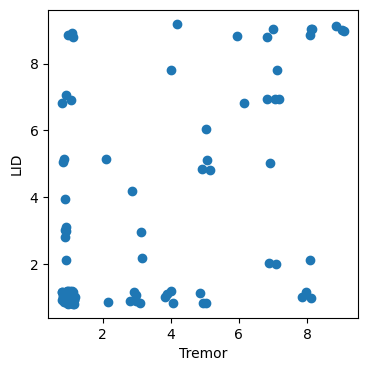

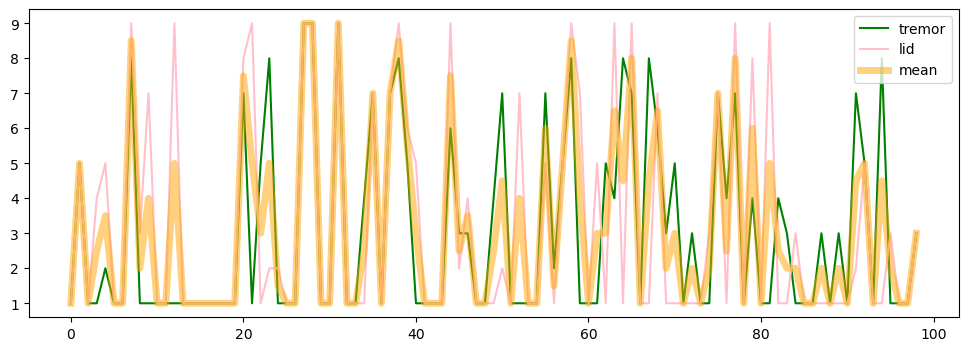

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(trems + np.random.uniform(-.2, .2, len(trems)),
            dys + np.random.uniform(-.2, .2, len(dys)))
ax.set_xlabel('Tremor')
ax.set_ylabel('LID')

plt.show()



fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(trems, color='green', label='tremor',)
ax.plot(dys, color='pink', label='lid')
ax.plot(np.mean([trems, dys], axis=0), color='orange', lw=5, alpha=.5, label='mean')

ax.legend()

plt.show()

In [65]:
FEATS_INCL = {
    'jerk_magn': True,
    'svm_sd': True,
    'svm_var': True,
    'pow_1_4': True,
    'pow_4_8': True, 
    'pow_2ndFreq': True,
    'corrcoef_components': True,
}
EMA_TARGET = 'Q8'  # dyskinesia
EMA_CONF = 'Q7'  # tremor

EXCL_CONFOUNDERS = False
CONF_CUT = 5

### create X-array with features per window
X_lists, y_lists = [], []
conf_list = []
day_list = []  # for grouping random variables

for i_win, windat in enumerate(all_windows):
    
    print(f'start # {i_win+1} / {len(all_windows)}')

    ### create y-array with EMA-label per window
    conf_value = float(windat.ema[EMA_CONF])
    if EXCL_CONFOUNDERS:
        if conf_value >= CONF_CUT: continue

    conf_list.append(conf_value)
    
    y_lists.append(float(windat.ema[EMA_TARGET]))
    
    tempfts, ft_keys = get_feats_for_window(
        windatClass=windat,
        FEATS_INCL=FEATS_INCL,
        SUMMARY_METH='mean',  # 90perc, mean
        SEG_LEN_SEC=1,
    )

    X_lists.append(tempfts)

    # get day for later splitting
    day_list.append(windat.day)

# make arrays
X_arr = np.array(X_lists)
# zscore
m, sd = np.mean(X_arr, axis=0), np.std(X_arr, axis=0)
X_arr[:, :] -= m
X_arr[:, :] /= sd

y_arr = np.array(y_lists)
# y_arr = EMA_Y  # mean tremor and lid
conf_arr = np.array(conf_list)

uniq_days = np.unique(day_list)
day_codes = {str(d): i_day for i_day, d in enumerate(uniq_days)}
daycode_arr = np.array([day_codes[d] for d in day_list])


start # 1 / 99
created windowData class for hm24, ses01;starttime 2025-07-12 20:29:13
belonging to day 2025-07-12
[1] {'peak_heights': array([0.00853937])} [0]
start # 2 / 99
created windowData class for hm24, ses01;starttime 2025-07-13 08:48:40
belonging to day 2025-07-13


c:\Users\habetsj\Research\projects\EMA_validation\EMA_clinic_validation\code\utils\acc_features.py:36: UserWarning: nperseg=32 is greater than signal length max(len(x), len(y)) = 31, using nperseg = 31
  fx, psx = welch(


start # 3 / 99
created windowData class for hm24, ses01;starttime 2025-07-13 10:59:01
belonging to day 2025-07-13
start # 4 / 99
created windowData class for hm24, ses01;starttime 2025-07-13 12:58:21
belonging to day 2025-07-13
[5] {'peak_heights': array([0.03225768])} [0]
start # 5 / 99
created windowData class for hm24, ses01;starttime 2025-07-14 13:08:22
belonging to day 2025-07-14
start # 6 / 99
created windowData class for hm24, ses01;starttime 2025-07-14 15:37:59
belonging to day 2025-07-14
start # 7 / 99
created windowData class for hm24, ses01;starttime 2025-07-15 10:21:14
belonging to day 2025-07-15
start # 8 / 99
created windowData class for hm24, ses01;starttime 2025-07-15 14:16:48
belonging to day 2025-07-15
[3] {'peak_heights': array([0.02334703])} [0]
start # 9 / 99
created windowData class for hm24, ses01;starttime 2025-07-15 19:41:54
belonging to day 2025-07-15
[2] {'peak_heights': array([0.00216233])} [0]
start # 10 / 99
created windowData class for hm24, ses01;startti

c:\Users\habetsj\Research\projects\EMA_validation\EMA_clinic_validation\code\utils\acc_features.py:36: UserWarning: nperseg=32 is greater than signal length max(len(x), len(y)) = 31, using nperseg = 31
  fx, psx = welch(


start # 46 / 99
created windowData class for hm24, ses01;starttime 2025-07-28 10:39:59
belonging to day 2025-07-28
[3] {'peak_heights': array([0.00010241])} [0]
[9] {'peak_heights': array([0.00097279])} [0]
[2] {'peak_heights': array([0.11917417])} [0]
[2] {'peak_heights': array([0.05639163])} [0]
[9] {'peak_heights': array([0.00075794])} [0]
start # 47 / 99
created windowData class for hm24, ses01;starttime 2025-07-28 20:08:03
belonging to day 2025-07-28
start # 48 / 99
created windowData class for hm24, ses01;starttime 2025-07-29 12:45:07
belonging to day 2025-07-29
start # 49 / 99
created windowData class for hm24, ses01;starttime 2025-07-30 16:37:53
belonging to day 2025-07-30
start # 50 / 99
created windowData class for hm24, ses01;starttime 2025-07-30 20:08:27
belonging to day 2025-07-30
start # 51 / 99
created windowData class for hm24, ses01;starttime 2025-07-31 14:03:39
belonging to day 2025-07-31
start # 52 / 99
created windowData class for hm24, ses01;starttime 2025-07-31 14

In [ ]:
# ### test pca idea for feature --> has to go up in ft dev

# pca = PCA(n_components=3)
# comps = pca.fit_transform(windat.acc_triax)
# stat, p = pearsonr(abs(comps[:, 0]), abs(comps[:, 1]))

# print('explained variance ratio', pca.explained_variance_ratio_)
# print('singular values', pca.singular_values_)

In [ ]:
# plt.plot(abs(comps[:, 0]))
# plt.plot(abs(comps[:, 1]))
# plt.show()

# stat, p = pearsonr(abs(comps[:, 0]), abs(comps[:, 1]))

# stat, p

test stats

In [ ]:
# statdf = np.concat([X_arr, y_arr.reshape(-1, 1)], axis=1)
# stat_df = pd.DataFrame(statdf, columns=ft_keys + ['EMA'])

In [ ]:
# Random intercepts only
model = smf.mixedlm(
    f"UPDRS_SUM_{motor_target} ~ {lmm_fix[FIX_EFF]}",
    lmm_df,
    # groups=lmm_df["subid"],
    # re_formula=f"~EMA_SUM_{motor_target}",  # for random slopes for EMA motor
)
result = model.fit()
print(result.summary())

In [ ]:
for i_f, f in enumerate(ft_keys):
    
    res = spearmanr(X_arr[:, i_f], y_arr)

    print(f'\n{f}: {res.statistic.round(2)}, p = {res.pvalue.round(5)}')

    plt.scatter(y_arr, X_arr[:, i_f])
    plt.close()

In [ ]:
model = MixedLM(endog=y_arr, exog=X_arr, groups=daycode_arr)
result = model.fit()

In [ ]:
result.summary()

In [ ]:
result.fe_params

result.cov_re

#### Test prediction

In [43]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score, r2_score,
    roc_auc_score, balanced_accuracy_score
)
from scipy.stats import f as stats_f
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import f_regression


In [41]:
def get_f_stat(y_pred, y_true, n_feats):
    # F-statistic for model usability
    
    # Sum of squares
    SSR = np.sum((y_pred - np.mean(y_true)) ** 2)   # Regression
    SSE = np.sum((y_true - y_pred) ** 2)   # Error
    SST = np.sum((y_true - np.mean(y_true)) ** 2)   # Total

    # Degrees of freedom
    df_reg = n_feats
    df_err = len(y_true) - (n_feats + 1)  # +1 for coeff next to betas of features

    # Mean squares
    MSR = SSR / df_reg if df_reg > 0 else np.nan
    MSE = SSE / df_err if df_err > 0 else np.nan
    F = MSR / MSE
    # p-value for the observed F
    f_pval = 1 - stats_f.cdf(F, df_reg, df_err)

    return F, f_pval

proof of concept:
- 1 sec segments
- mean as averaging method
- LDA for EMA prediction

In [71]:
models = {'scale': LinearRegression(),
          'lda': LDA(),
          'bin': LogisticRegression()}


CLSF = 'lda'

# TEST_SEL = daycode_arr > 25  # takes circa .33

# X_train = X_arr[~TEST_SEL, :]
# y_train = y_arr[~TEST_SEL]

# # test cohort
# X_test = X_arr[TEST_SEL, :]
# y_true = y_arr[TEST_SEL]


# y_pred to fill (LOdayO)
y_true = y_arr.astype(int)
y_pred = np.zeros_like(y_true)

# MAKE BINARY
if CLSF == 'bin':
    y_train = y_train >= 5
    y_true = y_true >= 5

# Run prediction

# leave one day out CV
for day in np.unique(daycode_arr):

    TEST_SEL = daycode_arr == day
    X_train = X_arr[~TEST_SEL, :]
    y_train = y_arr.astype(int)[~TEST_SEL]

    # test cohort
    X_test = X_arr[TEST_SEL, :]

    model = models[CLSF]
    model.fit(X_train, y_train)

    y_pred[TEST_SEL] = model.predict(X_test)



# round predictions to full numbers
if CLSF == 'scale' or 'lda': 
    y_pred = np.array([np.round(v) for v in y_pred])

    pred_F, pred_F_p = get_f_stat(y_pred=y_pred, y_true=y_true, n_feats=X_test.shape[1])
    pred_corrcoef, prs_p = pearsonr(y_true, y_pred)
    sk_f, sk_f_p = f_regression(y_pred.reshape(-1, 1), y_true)

    acc = accuracy_score(y_true, y_pred)
    R2 = r2_score(y_true=y_true, y_pred=y_pred,)

    print(f'({CLSF}) accuracy: {np.round(acc, 2)} (test sample: n={len(y_true)})')
    print(f'({CLSF}) R2: {np.round(R2, 2)} (test sample: n={len(y_true)})')
    print(f'({CLSF}) Corr-Coeff: {np.round(pred_corrcoef, 2)}, p={np.round(prs_p, 5)} (test sample: n={len(y_true)})')
    print(f'({CLSF}) F-stat: {np.round(pred_F, 2)}, p={pred_F_p}')
    print(f'({CLSF}) F-stat (sklearn): {np.round(sk_f, 2)}, p={np.round(sk_f_p, 5)}')


elif  CLSF == 'bin':
    auc = roc_auc_score(y_true=y_true, y_score=y_pred)
    print(f'({CLSF}) AUROC: {np.round(auc, 2)} (test sample: n={len(y_true)})')


(lda) accuracy: 0.55 (test sample: n=99)
(lda) R2: -0.13 (test sample: n=99)
(lda) Corr-Coeff: 0.42, p=2e-05 (test sample: n=99)
(lda) F-stat: 10.09, p=2.7995012974457723e-09
(lda) F-stat (sklearn): [20.72], p=[2.e-05]


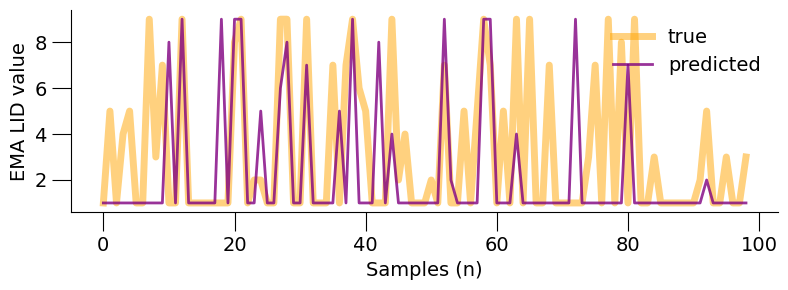

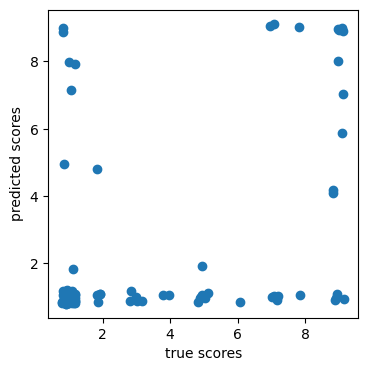

In [72]:
fig, ax = plt.subplots(1,1, figsize=(8, 3))

ax.plot(y_true, color='orange', lw=5, alpha=.5,
         label='true',)
ax.plot(y_pred, color='purple', lw=2, alpha=.8,
         label='predicted')

ax.set_xlabel('Samples (n)', size=14)
ax.set_ylabel('EMA LID value', size=14)
ax.legend(frameon=False, fontsize=14, loc='upper right')

ax.tick_params(axis='both', size=14, labelsize=14,)
ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()

# plt.savefig(os.path.join(load_utils.get_onedrive_path('figures'),
#              'proof_kin_pred', 'LID_pred_hm24_ses01_24nov'),
#              dpi=300, facecolor='w',)

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.scatter(y_true + np.random.uniform(-.2, .2, len(y_true)),
            y_pred + np.random.uniform(-.2, .2, len(y_pred)),)
ax.set_xlabel('true scores')
ax.set_ylabel('predicted scores')

plt.show()

Perm test

In [68]:
N_PERMS = 1000

# TEST_SEL = daycode_arr > 20  # takes circa .33

# X_train = X_arr[~TEST_SEL, :]
# y_train = y_arr[~TEST_SEL]

# # test cohort
# X_test = X_arr[TEST_SEL, :]
# y_true = y_arr[TEST_SEL]

model = LDA()

# Run prediction
perm_mets ={'F': [], 'R': []}

y_true = y_arr.astype(int)

np.random.seed(27)

for i_perm in np.arange(N_PERMS):

    y_perm_pred = np.array([np.nan] * len(y_arr))

    for day in np.unique(daycode_arr):

        TEST_SEL = daycode_arr == day
        X_train = X_arr[~TEST_SEL, :]
        y_train = y_arr.astype(int)[~TEST_SEL]
        np.random.shuffle(y_train)   

        # test cohort
        X_test = X_arr[TEST_SEL, :]

        model = models[CLSF]
        model.fit(X_train, y_train)

        y_perm_pred[TEST_SEL] = model.predict(X_test)

    # y_train = y_arr[~TEST_SEL]
    # np.random.shuffle(y_train)   
    # model.fit(X_train, y_train)

    # y_perm_pred = model.predict(X_test)
    # # np.random.shuffle(y_perm_pred)
    y_perm_pred = np.array([np.round(v) for v in y_perm_pred])

    F, f_pvalue = get_f_stat(y_pred=y_perm_pred, y_true=y_true,
                             n_feats=X_test.shape[1])
    prs_stat, _ = pearsonr(y_perm_pred, y_true)
    perm_mets['F'].append(F)
    perm_mets['R'].append(prs_stat)




metric F: p = 0.0
metric R: p = 0.012


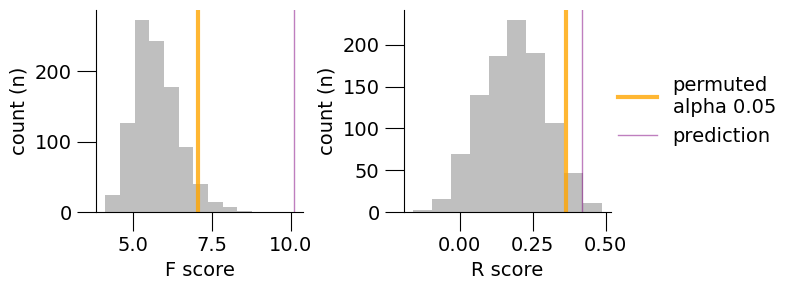

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

pred_mets = {'F': pred_F, 'R': pred_corrcoef}

for i_ax, metr in enumerate(list(perm_mets.keys())):

    axes[i_ax].hist(perm_mets[metr], color='gray', alpha=.5,)
    axes[i_ax].axvline(np.percentile(perm_mets[metr], 95),
                       color='orange', alpha=.8, lw=3,
                       label='permuted\nalpha 0.05',)
    
    axes[i_ax].axvline(pred_mets[metr],
                       color='purple', alpha=.5, lw=1,
                       label='prediction',)
    
    p_calc = sum(pred_mets[metr] < perm_mets[metr]) / len(perm_mets[metr])
    print(f'metric {metr}: p = {np.round(p_calc, 3)}')

    axes[i_ax].set_xlabel(f'{metr} score', size=14,)

    axes[i_ax].set_ylabel('count (n)', size=14)

    axes[i_ax].tick_params(axis='both', size=14, labelsize=14,)
    axes[i_ax].spines[['right', 'top']].set_visible(False)

axes[1].legend(frameon=False, fontsize=14,
               bbox_to_anchor=(.95, .5), loc='center left')

plt.tight_layout()

# plt.savefig(os.path.join(load_utils.get_onedrive_path('figures'),
#              'proof_kin_pred', 'LID_pred_hm24_ses01_24nov_perms'),
#              dpi=300, facecolor='w',)

plt.show()

Get submovement indices

use per window:
- n submovements / min
- mean length
- variation of lengths

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# loop over each day
for day_idx, day in enumerate(home_dat.watch_days):
    
    # if day_idx > 0: continue  # ONLY EXECUTE ONE DAY FOR DEVELOPMENT
    
    print(f'\nStart day i-{day_idx}: {day}')
    print('load acc day')
    day_accClass = moveProc.get_accel_day(dat=home_dat, day_index=day_idx,)

   

    print('compute act index')
    # calculate act index
    ai_values, ai_times = moveProc.compute_activity_index(
        day_accClass.raw_triax_acc,
        day_accClass.timestamps
    )
    print('cluster ai')
    # cluster act indices
    kmeans = KMeans(
        n_clusters=2, random_state=0, n_init="auto"
    ).fit(ai_values.reshape([-1, 1]))

    ai_binary_clusters = kmeans.labels_

In [ ]:
importlib.reload(load_data)
importlib.reload(prep_data)





# load all combined data

# SUBS_INCL = ['hm14']


emadata = {m: {} for m in MOMENTS}
accdata = {m: {} for m in MOMENTS}

for rec_moment, sub_sess in sessions_include.items():

    for sub, ses in sub_sess.items():
        print(f'\n\n{"#" * 30}\nstart sub-{sub}: ses:{ses}\n{"#" * 30}\n\n')

        # to test acc loading
        # if not sub in SUBS_INCL: continue

        if sub in sub_skip: continue
                    
        if [sub, ses] in ses_skip: continue
                
        ses_class = load_home.loadSubject(
            sub=sub,
            ses=ses,
            incl_EMA=True,
            incl_ACC=True,
        )
        # temp_df = ema_utils.load_ema_df(sub_ses_class=ses_class)
        # # prepare
        # temp_df = prep_data.prepare_ema_df(temp_df, ADD_MEANMOVE=True, INVERT_NEG_ITEMS=False,)
        ### TODO: CHECK WHY NOT ALL SUBS ARE INVERTED PROPERLY

        # emadata[rec_moment][sub] = temp_df

        ################
        # store and plot acc feasib acquisition
        
        # get feas/acquisition numbers
        sub_timesums = get_acc_feas(ses_class)

        # Save with highest protocol (fast & compact)
        fname = f"acc_seconds_{ses_class.sub}_{ses_class.ses}.pkl"

        with open(os.path.join(feas_data_path, fname), "wb") as f:
            pickle.dump(sub_timesums, f,
                        protocol=pickle.HIGHEST_PROTOCOL)

        plot_feas_acc(sub_timesums=sub_timesums,
                      sub=ses_class.sub, ses=ses_class.ses)


In [ ]:
plot_feas_acc(sub_timesums=feasload, sub=SUB, ses=SES)

In [ ]:
importlib.reload(load_watch)
importlib.reload(load_home)
importlib.reload(dbs_home)


temp = load_home.loadSubject(
            sub='hm23',
            ses='ses01',
            incl_EMA=True,
            incl_ACC=True,
            proc_ACC=False,
        )

In [ ]:
import dbs_home.utils.finding_paths as home_paths

In [ ]:
temp.sub

#### explore kinematic features

In [ ]:

# create dict with ACC data per EMA window

acc_ema_combis = {}

for i_day, str_day in enumerate(home_dat.watch_days):
    # define current day
    print(str_day)
    # check default parameters here
    acc_ema_combis[str_day] = acc_prep.get_day_EMA_AccWindows(
        subSesClass=home_dat, str_day=str_day,
    )
    


   

In [ ]:
EMA_PICK = {'LID': 'Q8'}

In [ ]:
ema_values = {k: [] for k in EMA_PICK.keys()}
feats = {}

# day_i = 0
# day_key = list(acc_ema_combis.keys())[day_i]

for day_i, (day_key, day_dict) in enumerate(
    acc_ema_combis.items()
):

# ema_i = 0
    for ema_i in np.arange(len(acc_ema_combis[day_key]['ema'])):

        # ADD SELECTED EMA values
        for key, code in EMA_PICK.items():
            ema_values[key].append(
                acc_ema_combis[day_key]['ema'][ema_i][code]
            )
        

In [ ]:
plt.plot(ema_values['LID'])

explore feasbility, completion rates for acc

In [ ]:
def get_acc_feas(
    dataClass_acc,
    TIME_GAP_SEC = 1,
    ACC_SFREQ = 32,
):

    sub_timesums = {}

    for i_day, day in enumerate(dataClass_acc.watch_days):
        print(f'\n\n{day}')
        time_sum = dt.timedelta(0)  # store collected time sum in variable dt timedelta

        time_diff = np.diff(dataClass_acc.acc_times[i_day][::(ACC_SFREQ * TIME_GAP_SEC)])  # use every 1-second value

        per_start, per_end = None, None

        for t_df, stamp in zip(
            time_diff,
            dataClass_acc.acc_times[i_day][::(ACC_SFREQ * TIME_GAP_SEC)]
        ):  # loop over timedeltas

            if not per_start:
                per_start = stamp
                # print(f'\nstartis {per_start}')
                continue

            # if too large time gap
            if t_df > dt.timedelta(seconds=TIME_GAP_SEC):
                per_end = stamp
                # add period times to list
                time_sum += (per_end - per_start)
                # reset period times and start over
                per_start, per_end = None, None

        if per_start and not per_end:
            per_end = stamp
            # add period times to list
            time_sum += (per_end - per_start)
            
        # store day sum in sub dict
        sub_timesums[day] = time_sum

    return sub_timesums


In [ ]:
import pickle

In [ ]:
# # Load

SUB='hm23'
SES='ses01'

fname = f"acc_seconds_{SUB}_{SES}.pkl"

with open(os.path.join(feas_data_path, fname), "rb") as f:
    feasload = pickle.load(f)

In [ ]:
feasload

In [ ]:
def plot_feas_acc(sub_timesums, sub, ses):

       fname = f'ACC_collection_{sub}_{ses}'

       fig, ax = plt.subplots(1, 1, figsize=(9, 3))

       ax.bar(x=np.arange(len(sub_timesums)),
              height=[t.seconds / 3600 for t in sub_timesums.values()])

       ax.set_xticklabels([l for l in sub_timesums.keys()],
                     rotation=45,)
       ax.set_xticks(np.arange(len(sub_timesums.values())),)
       ax.set_ylabel('Day sum (hours)')
       ax.set_title(f'collected ACC-time: {sub}, {ses}')

       plt.tight_layout()

       plt.savefig(os.path.join(feas_fig_path, fname), dpi=300,
                     facecolor='w', )

       plt.close()


## 2. Preprocess data: explore and visualize

#### Get (mean-corrected) EMA and UPDRS values per symptom subtype

In [ ]:
importlib.reload(load_data)
importlib.reload(prep_data)

predat = ema_dat['hm14'].copy()
# dat = prep_data.prepare_home_emas(predat)

In [ ]:
ema_dat['hm20'].columns

## 3. Explore / visualize data

In [ ]:
figpath = load_utils.get_onedrive_path('emaval_fig')


In [ ]:
ema_dat['hm18'].keys()

In [ ]:
for sub, dat in ema_dat.items():

    daystart = dat['dates'].iloc[0]

    dayend = dat['dates'].iloc[-1]

    daystart = sel_info.loc[sub]['onboarding_date'] + dt.timedelta(days=1)
    dayend = sel_info.loc[sub]['checkout_date'] - dt.timedelta(days=1)


    ndays = (dayend - daystart).days

    
    compl_perc = dat.shape[0] / (ndays * 6)

    print(f'{sub}: over {ndays} days completed {np.round(compl_perc, 2)}')


# ema_dat['hm18']['dates']

## 4. Perform Statistics

In [ ]:
import utils.stats as utilsstat
import statsmodels.formula.api as smf
